- Indentifier les sections relatives au climat
- Une analyse de sentiment sur ces articles

In [ ]:
os.chdir('..')
os.getcwd()

In [25]:
# Import des librairies
import re,os,glob,time,sys
from pathlib import Path
import pandas as pd 
import numpy as np
import math
from numpy import arange
import seaborn as sns
import matplotlib.pyplot as plt
# Pour les warnings
import warnings
warnings.filterwarnings('ignore')
# Pour le traitement de texte
import nltk
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import (
    sent_tokenize,
    word_tokenize,
    wordpunct_tokenize,
)
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from quotaclimat.data_ingestion.config_sitmap import MEDIA_CONFIG, SITEMAP_CONFIG
from quotaclimat.data_processing.sitemap.sitemap_processing import load_webpress,preprocess
from quotaclimat.utils import functions

In [26]:
#Modification des paramètres d'affichages des colonnes, lignes et largeurs des colonnes pour obtenir le 
#plus d'informations
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('float_format',lambda x: "%.4f" % x)

In [27]:
# Load sitemap data
df = load_webpress()

- Exploration des données : 

In [17]:
df.head()

,url,news,news_publication,publication_name,publication_language,news_publication_date,news_title,news_keywords,image,image_loc,image_caption,sitemap,etag,sitemap_last_modified,sitemap_size_mb,download_date,media,section,changefreq,news_access,image_title,lastmod,news_genres,priority,download_date_last,media_type
105623,https://www.lamarseillaise.fr/politique/aix-en-provence-cinq-verites-politiques-de-sophie-joissains-pour-debuter-2023-JH13050595,,,Journal La Marseillaise,fr,2023-01-17 11:55:24,Aix-en-Provence : cinq vérités politiques de Sophie Joissains pour débuter 2023,None,,https://www.lamarseillaise.fr/binrepository/img-0920-2_542-6641535_20230117090309.jpg,"Sophie Joissains n’a pas la faconde de sa mère Maryse Joissains (maire de 2001 à 2021). Mais elle a le goût du contact, et renoue avec les rendez-vous de communication politiques. PHOTO J.N.",https://www.lamarseillaise.fr/base-portlet/webrsrc/c271c72bfbcbe7c22eed98b1da8f89dd.xml,None,NaT,0.0373,2023-01-18 01:39:16,lamarseillaise,[politique],hourly,Subscription,None,None,None,NaN,2023-01-19 01:41:00,webpress
105624,https://www.lamarseillaise.fr/societe/une-expropriation-irreguliere-coute-579-millions-d-euros-a-gemenos-EH13050567,,,Journal La Marseillaise,fr,2023-01-17 11:20:49,"Une expropriation irrégulière coûte 5,79&nbsp;millions d’euros à Gémenos",None,,https://www.lamarseillaise.fr/binrepository/2023-01-16_542-6641524_20230117090224.jpg,"Les 57&nbsp;965 m2 de terrains expropriés pour 298&nbsp;000 euros en 1991 ont pris une valeur considérable : 5,79 millions d’euros au jour du jugement de 2013, sans compter les intérêts. photo dr",https://www.lamarseillaise.fr/base-portlet/webrsrc/c271c72bfbcbe7c22eed98b1da8f89dd.xml,None,NaT,0.0373,2023-01-18 01:39:16,lamarseillaise,[societe],hourly,Subscription,None,None,None,NaN,2023-01-19 01:41:00,webpress
105625,https://www.lamarseillaise.fr/societe/gard-les-urgences-sont-saturees-et-tirent-la-sonnette-d-alarme-EH13052204,,,Journal La Marseillaise,fr,2023-01-17 15:50:36,Gard : les urgences sont saturées et tirent la sonnette d’alarme,None,,https://www.lamarseillaise.fr/binrepository/1_542-6591522_20230117154424.jpg,Les services d’urgences gardois ne tiennent qu’à un fil depuis plusieurs semaines. PHOTO AFP,https://www.lamarseillaise.fr/base-portlet/webrsrc/c271c72bfbcbe7c22eed98b1da8f89dd.xml,None,NaT,0.0373,2023-01-18 01:39:16,lamarseillaise,[societe],hourly,None,None,None,None,NaN,2023-01-19 01:41:00,webpress
105626,https://www.lamarseillaise.fr/politique/la-seyne-sur-mer-le-budget-2023-en-ligne-de-mire-du-conseil-municipal-AH13054325,,,Journal La Marseillaise,fr,2023-01-17 19:40:22,La Seyne-sur-Mer: le budget 2023 en ligne de mire du conseil municipal,None,,https://www.lamarseillaise.fr/binrepository/20230117_542-6651152_20230117193459.jpg,Ambiance studieuse ce mardi lors du premier conseil municipal de l’année. <br />Photo Cesar Mazouzi,https://www.lamarseillaise.fr/base-portlet/webrsrc/c271c72bfbcbe7c22eed98b1da8f89dd.xml,None,NaT,0.0373,2023-01-18 01:39:16,lamarseillaise,[politique],hourly,Subscription,None,None,None,NaN,2023-01-19 01:41:00,webpress
105627,https://www.lamarseillaise.fr/societe/fin-de-la-selection-a-paul-valery-BH13051176,,,Journal La Marseillaise,fr,2023-01-17 12:37:07,Fin de la sélection à Paul Valéry ?,None,,https://www.lamarseillaise.fr/binrepository/img_542-6634578_20230117121312.jpg,"Le SCUM, ici en action, a fait voter la fin de la sélection à l’université Paul Valéry de Montpellier. PHOTO SCUM",https://www.lamarseillaise.fr/base-portlet/webrsrc/c271c72bfbcbe7c22eed98b1da8f89dd.xml,None,NaT,0.0373,2023-01-18 01:39:16,lamarseillaise,[societe],hourly,None,None,None,None,NaN,2023-01-21 01:30:30,webpress


In [11]:
df.sample(100)

,url,news,news_publication,publication_name,publication_language,news_publication_date,news_title,news_keywords,image,image_loc,image_caption,sitemap,etag,sitemap_last_modified,sitemap_size_mb,download_date,media,section,changefreq,news_access,image_title,lastmod,news_genres,priority,download_date_last,media_type
93,https://amp.lefigaro.fr/story/football-ligue1-2022-2023-28emejournee-toulouse-vs-lille-15945,,,Le Figaro,fr,2023-03-18 19:13:02,Lille domine Toulouse,"Football, Ligue 1 2022 2023, Ligue_1-2022-2023, Toulouse, Lille, Alexsandro Ribeiro, Bayo, feuille de match, résumé, stats, statistiques",,https://a.f1g.fr/h/assets-mobile/papator_assets/ligue1_push_img/427-429.jpeg,None,https://www.lefigaro.fr/sitemap_news.xml,NaN,NaT,0.6883,2023-03-19 10:37:20,lefigaro,[unknown],NaN,NaN,NaN,2023-03-18 18:13:02,None,NaN,NaT,webpress
327,https://www.ladepeche.fr/2023/02/08/loto-des-ecoliers-samedi-soir-10983657.php,NaN,NaN,NaN,NaN,NaT,NaN,NaN,,https://images.ladepeche.fr/api/v1/images/view/63e3225ea608e62eed6775e5/hd/image.jpg,NaN,https://www.ladepeche.fr/sitemap_articles_1.xml.gz,NaN,NaT,3.6849,2023-02-09 01:41:09,ladepeche,unknown,daily,NaN,NaN,2023-02-08 03:12:22,NaN,1.0000,NaT,webpress
63,https://www.midilibre.fr/2023/02/10/surendettement-dune-vie-dopulence-a-credit-a-une-vie-ou-je-me-refuse-tout-recit-dun-engrenage-infernal-10986930.php,NaN,NaN,NaN,NaN,NaT,NaN,NaN,,https://images.midilibre.fr/api/v1/images/view/63e51f718a7d7e13d9306591/hd/image.jpg,NaN,https://www.midilibre.fr/sitemap_articles_1.xml.gz,NaN,NaT,3.8241,2023-02-12 01:43:29,midilibre,unknown,daily,NaN,NaN,2023-02-11 10:46:43,NaN,1.0000,NaT,webpress
1062,https://www.ladepeche.fr/2023/02/03/lot-et-garonne-chez-les-savinien-le-rugby-se-transmet-de-pere-en-fils-10972473.php,NaN,NaN,NaN,NaN,NaT,NaN,NaN,,https://images.ladepeche.fr/api/v1/images/view/63dd1a96b1092838a07290a1/hd/image.jpg,NaN,https://www.ladepeche.fr/sitemap_articles_1.xml.gz,NaN,NaT,3.6873,2023-02-08 01:42:34,ladepeche,unknown,daily,NaN,NaN,2023-02-05 10:32:37,NaN,1.0000,NaT,webpress
132,https://www.lemonde.fr/sport/article/2023/02/06/mondiaux-de-ski-2023-federica-brignone-titree-en-combine-shiffrin-cede_6160751_3242.html,NaN,NaN,Le Monde,fr,2023-02-06 17:57:00,"Mondiaux de ski 2023 : Federica Brignone titrée en combiné, Shiffrin cède",NaN,NaN,https://img.lemde.fr/2023/02/06/463/0/5559/2779/1440/720/60/0/493403f_8bf70fde579447d5ae17f6c74967fd6c-0-4b906853a17c484ba6acaf607cc19552.jpg,"L’Italienne Federica Brignone sacrée championne du monde de combiné, à Méribel, lundi 6 février.",https://www.lemonde.fr/sitemap_news.xml,"""8f3e8c9bb89904bfc02063048c930517""",2023-02-08 01:42:10+00:00,0.1586,2023-02-08 01:42:15,lemonde,"[sport, article]",NaN,NaN,NaN,2023-02-06 16:57:00,NaN,NaN,NaT,webpress
292,https://www.ladepeche.fr/2023/03/18/le-jump-rope-club-saute-de-succes-en-succes-11070555.php,NaN,NaN,NaN,NaN,NaT,NaN,NaN,,https://images.ladepeche.fr/api/v1/images/view/64153c1b4c501e0840531ba9/hd/image.jpg,NaN,https://www.ladepeche.fr/sitemap_articles_1.xml.gz,NaN,NaT,3.6883,2023-03-19 10:37:34,ladepeche,unknown,daily,NaN,NaN,2023-03-18 04:14:07,NaN,1.0000,NaT,webpress
51358,https://www.lefigaro.fr/flash-actu/l-iran-convoque-l-ambassadeur-d-italie-pour-denoncer-l-interventionnisme-20221230,\n,\n,Le Figaro,fr,2022-12-30 10:18:59,L'Iran convoque l'ambassadeur d'Italie pour dénoncer l'«interventionnisme»,"Iran, Italie, Flash, Flash Actu, Fil, Fil info, Breves, Actualite, news, informations, actualités, actu, depeches, nouvelles, infos, France, international, politique, faits divers",\n,https://i.f1g.fr/media/cms/orig/2022/12/30/3e0875c59bd069f09cdb6e0165b065d7bb7fdca172d58b6f0e70d98483b7eca9.jpg,"Le ministre iranien des Affaires étrangères Hossein Amirabdollahian à Téhéran, le 23 novembre 2022.",https://www.lefigaro.fr/sitemap_news.xml,None,NaT,0.6802,2022-12-31 01:27:04,lefigaro,[flash-actu],None,None,None,2022-12-30 10:45:42+00:00,None,NaN,2023-01-01 01:48:01,webpress
904,https://www.midilibre.fr/2023/02/16/lartiste-c

- Le but est extraire en premier lieu les sections que nous utiiserons plus tard pour la définition des articles liés au climat
- Les sections sont sous forme de liste et sur la plupart des on trouve plusieurs niveaux: [economie, social],[weekend, business-story],[sports, football, equipe-de-france],[sport, article],[environnement, climat],[industrie-services, tourisme-transport], [finistere, plouigneau], [sport, football]
- Nous pouvons pour réduire le nombre de sections se contenter du premier niveau : [sports, football, equipe-de-france] --> sports, [sport, football]--> sport

- Nettoyage des données : 

- Extraction de la section: cette colonne est sous forme de liste

- Colonnes inutiles

- Concaténation titre et texte d'image

In [28]:
df=preprocess(df)

In [21]:
df.sample(10)

,url,news_publication_date,news_title,image_caption,etag,download_date,media,section,text
1471,https://www.ladepeche.fr/2023/02/09/prix-developpement-durable-10987297.php,None,None,None,None,2023-02-13 01:45:20,ladepeche,u,None None
1012,https://www.lindependant.fr/2023/02/05/perpignan-la-soprano-catalane-alexandra-marcellier-nominee-aux-victoires-de-la-musique-classique-2023-10939850.php,None,None,None,None,2023-02-13 01:45:17,lindependant,u,None None
84209,https://www.lepoint.fr/monde/la-cour-supreme-maintient-une-mesure-de-trump-bloquant-les-migrants-a-la-frontiere-20-12-2022-2502319_24.php,2022-12-20 07:20:00,La Cour suprême maintient une mesure de Trump bloquant les migrants à la frontière,"La Cour suprême a maintenu lundi une mesure mise en œuvre en mars 2020 sous l'ère Trump permettant d’expulser les candidats à l’immigration, même les demandeurs d’asile potentiels.\n",None,2022-12-21 01:25:26,le_point,monde,"La Cour suprême maintient une mesure de Trump bloquant les migrants à la frontière La Cour suprême a maintenu lundi une mesure mise en œuvre en mars 2020 sous l'ère Trump permettant d’expulser les candidats à l’immigration, même les demandeurs d’asile potentiels.\n"
28,https://www.lamarseillaise.fr/sports/les-handisportifs-regionaux-ont-fait-leurs-jeux-LB13305835,2023-02-17 07:28:00,Les handisportifs régionaux ont fait leurs jeux,L’athlétisme était au programme de ces 2e jeux régionaux de l’avenir handisport. PHOTO loïc guibert,None,2023-02-18 01:41:33,lamarseillaise,sports,Les handisportifs régionaux ont fait leurs jeux L’athlétisme était au programme de ces 2e jeux régionaux de l’avenir handisport. PHOTO loïc guibert
52009,https://www.lefigaro.fr/vox/societe/renaud-girard-defi-americain-autosatisfaction-europeenne-20230102,2023-01-02 19:24:32,"Renaud Girard: «Défi américain, autosatisfaction européenne»",Renaud Girard.,None,2023-01-03 01:27:26,lefigaro,vox,"Renaud Girard: «Défi américain, autosatisfaction européenne» Renaud Girard."
45384,https://www.lefigaro.fr/sports/football/coupe-du-monde/ambiance-volcanique-le-cadeau-de-ryan-coups-de-coeur-et-coups-de-griffe-apres-australie-australie-20221203,2022-12-03 22:54:42,"Ambiance volcanique, le cadeau de Ryan… Coups de cœur et coups de griffe de notre envoyé spécial après Argentine-Australie",Les supporters argentins ont mis le feu samedi soir...,None,2022-12-04 01:40:06,lefigaro,sports,"Ambiance volcanique, le cadeau de Ryan… Coups de cœur et coups de griffe de notre envoyé spécial après Argentine-Australie Les supporters argentins ont mis le feu samedi soir..."
78604,https://www.20minutes.fr/people/4018602-20230112-hilary-swank-ruser-cacher-grossesse-the-chainsmokers-racontent-plans-trois-fans,2023-01-12 17:35:05,Hilary Swank a dû ruser pour cacher sa grossesse… The Chainsmokers racontent leurs plans à trois avec des fans…,L'actrice Hilary Swank,None,2023-01-13 01:40:11,20_minutes,people,Hilary Swank a dû ruser pour cacher sa grossesse… The Chainsmokers racontent leurs plans à trois avec des fans… L'actrice Hilary Swank
3517,https://www.ladepeche.fr/2023/02/10/centre-bourg-la-phase-2-des-travaux-est-lancee-10988802.php,None,None,None,None,2023-02-17 01:46:24,ladepeche,u,None None
73539,https://www.20minutes.fr/monde/ukraine/4013730-20221207-crise-energetique-europe-vraiment-capacite-importer-gaz-naturel-liquefie,2022-12-07 12:12:36,Crise énergétique : L’Europe est-elle (vraiment) en capacité d’importer du gaz naturel liquéfié ?,L'une des réponses de l'Europe à la crise est l'augmentation des importations de gaz naturel liquéfié (GNL),None,2022-12-08 01:37:40,20_minutes,monde,Crise énergétique : L’Europe est-elle (vraiment) en capacité d’importer du gaz naturel liquéfié ? L'une des réponses de l'Europe à la crise est l'augmentation des importations de gaz naturel liquéfié (GNL)
2896,https://www.ladepeche.fr/2023/02/02/les-voeux-de-regine-fourcaud-10968484.php,None,None,None,None,2023-02-08 01:42:34,ladepeche,u,None None


- Vérification des NAN:

In [22]:
summary(df)

Data shape: (254226, 9)
___________________________
Data types:
object            8
datetime64[ns]    1
Name: types, dtype: int64
___________________________


,types,counts,uniques,nulls
download_date,datetime64[ns],254226,615,0
etag,object,254226,386,0
image_caption,object,254226,53405,0
media,object,254226,18,0
news_publication_date,object,254226,91624,0
news_title,object,254226,90982,0
section,object,254226,351,0
text,object,254226,92261,0
url,object,254226,127447,0


In [23]:
missing_values(df)

,Variable,nan,%nan
0,url,0,0.0000%
1,news_publication_date,0,0.0000%
2,news_title,0,0.0000%
3,image_caption,0,0.0000%
4,etag,0,0.0000%
5,download_date,0,0.0000%
6,media,0,0.0000%
7,section,0,0.0000%
8,text,0,0.0000%


In [24]:
df.groupby(["media","section"]).count()

url  news_publication_date  \
media               section                                                     
20_minutes          20-mint                         23                     23   
                    actu-generale                    6                      6   
                    arts-stars                      28                     28   
                    auto                           244                    244   
                    bordeaux                       148                    148   
                    by-the-web                     108                    108   
                    cinema                         208                    208   
                    culture                        494                    494   
                    diaporama                      370                    370   
                    economie                       516                    516   
                    elections                        1                      1   
                    emploi                          24                     24   
                    faits_divers                  1793                   1793   
                    food                             8                      8   
                    france                          38                     38   
                    gastronomie                     36                     36   
                    guide-achat                    640                    640   
                    high-tech                      264                    264   
                    hightech                         2                      2   
                    horoscope-quotidien            102                    102   
                    horoscope-quotidien-chinois    103                    103   
                    insolite                       193                    193   
                    justice                        920                    920   
                    lille                          130                    130   
                    livres                          91                     91   
                    loisirs                        112                    112   
                    lyon                           124                    124   
                    magazine                         1                      1   
                    marseille                      111                    111   
                    medias                          51                     51   
                    mode                            17                     17   
                    monde                         1792                   1792   
                    montpellier                    109                    109   
                    nantes                         151                    151   
                    nice                           121                    121   
                    noel                            11                     11   
                    paris                          436                    436   
                    people                         698                    698   
                    planete                        624                    624   
                    podcast                         50                     50   
                    politique                      417                    417   
                    publicommunique                  4                      4   
                    rennes                         133                    133   
                    sante                          390                    390   
                    sciences                       148                    148   
                    serie                           60                     60   
                    societe                       1923                   1923   
                    sortir                           1                      1   
 

In [25]:
df.media.value_counts()

ladepeche              60920
letelegramme           43911
midilibre              32468
lefigaro               28636
lindependant           17618
20_minutes             15997
lopinion               10341
lemonde                10120
centrepresseaveyron     6423
lesechos                5804
liberation              5673
le_point                4443
petitbleu               3067
investir.lesechos       2298
lexpress                2202
lequipe                 1665
nouvel_obs              1335
lamarseillaise          1305
Name: media, dtype: int64

In [26]:
df.section.value_counts()

u                              120496
finistere                       15460
cotes-darmor                    12114
morbihan                         9046
international                    7945
sports                           7886
economie                         6779
politique                        6231
societe                          5235
monde                            5066
culture                          3012
flash-actu                       2881
unknown                          2733
sport                            2217
flash-eco                        2132
faits_divers                     1793
football                         1437
conjoncture                      1256
actualite-france                 1115
justice                          1100
planete                          1016
idees                             987
vox                               913
pme-regions                       897
sciences                          897
industrie-services                894
voyages     

In [29]:
l_sect = list(set(df["section"]))
print("Sections : ", l_sect)

Sections :  ['', 'Velo-mag', 'weekend', 'idees-debats', 'people', 'langue-francaise', 'rugby', 'judo', 'vieilles-charrues', 'le-jazz-et-la-salsa', 'Cyclo-cross', 'voyages', 'cross-country', 'Formule-e', 'immobilier', 'flash-eco', 'musique', 'ecologie', 'montres', 'etats-unis', 'ce-soir-a-la-tv', 'invites-du-point', 'stories', 'rennes', 'secteur', 'festival-de-cannes', 'montpellier', 'basket', 'Aviron', 'omnisports', 'finistere', 'politique', 'joe-biden', 'pop-culture', 'jardin', 'tribune', 'actualite', 'rink-hockey', 'loisirs', 'equitation', 'sciences-nature', 'tir', 'Golf', 'asie', 'sciences', 'lefigaromagazine', 'televisions-radio', 'surf', 'patinage-artistique', 'coupe-du-monde', 'Gymnastique', 'Escrime', 'morbihan', 'horlogerie', 'hightech', 'astronomie', 'Hockey-sur-glace', 'guide-achat', 'vin', 'vous', 'o', 'Tous-sports', 'fait-divers', 'actu-generale', 'Football', 'vers-un-avenir-durable', 'auto', 'multimedia', 'mode', 'television', 'international', 'story', 'jeux', 'hockey-sur-

In [33]:
print("Il y a ",len(set(df['section'])), " sections")

Il y a  351  sections


In [77]:
#section agri-agro a voir ?
df[df["section"]=="o2-week-end"]

,url,news_publication_date,news_title,image_caption,etag,download_date,media,section,text
107411,https://www.lopinion.fr/o2-week-end/mr-ripley-prend-lavion-la-critique-de-bernard-quiriny,2023-01-17 09:28:56,«Mr Ripley prend l’avion». La critique de Bernard Quiriny,None,None,2023-01-19 01:41:02,lopinion,o2-week-end,«Mr Ripley prend l’avion». La critique de Bernard Quiriny None
107537,https://www.lopinion.fr/o2-week-end/chateau-de-pez-un-saint-estephe-qui-merite-le-detour,2023-01-23 12:18:13,"Château de Pez, un Saint Estèphe qui mérite le détour",Dans les coulisses du château de Pez.,None,2023-01-24 01:38:16,lopinion,o2-week-end,"Château de Pez, un Saint Estèphe qui mérite le détour Dans les coulisses du château de Pez."
107589,https://www.lopinion.fr/o2-week-end/abel-bonnard-du-symbolisme-au-fascisme-la-critique-de-bernard-quiriny,2023-01-24 09:07:21,"«Abel Bonnard, l'idéologue du fascisme français»",None,None,2023-01-25 01:29:03,lopinion,o2-week-end,"«Abel Bonnard, l'idéologue du fascisme français» None"
107447,https://www.lopinion.fr/o2-week-end/fortuny-lart-et-la-matiere,2023-01-19 01:31:09,Fortuny: l'art et la matière,Le luminaire Studio 76 dans sa version noir et Feuille d’Or,None,2023-01-20 01:39:03,lopinion,o2-week-end,Fortuny: l'art et la matière Le luminaire Studio 76 dans sa version noir et Feuille d’Or
107448,https://www.lopinion.fr/o2-week-end/maison-bonnet-un-regard-ultime,2023-01-19 01:32:25,"Maison Bonnet, un regard ultime",Maison Bonnet est spécialisée dans l'art de la lunetterie sur-mesure depuis les années 30.,None,2023-01-20 01:39:03,lopinion,o2-week-end,"Maison Bonnet, un regard ultime Maison Bonnet est spécialisée dans l'art de la lunetterie sur-mesure depuis les années 30."
107449,https://www.lopinion.fr/o2-week-end/la-galerie-dior-presentee-par-son-architecte,2023-01-19 01:33:10,La Galerie Dior présentée par son architecte,L'emblématique escalier de la Galerie Dior.,None,2023-01-20 01:39:03,lopinion,o2-week-end,La Galerie Dior présentée par son architecte L'emblématique escalier de la Galerie Dior.
107450,https://www.lopinion.fr/o2-week-end/quoi-de-neuf-dans-lactualite-lifestyle-14,2023-01-19 02:19:29,Quoi de neuf dans l'actualité Lifestyle ? #14,"S’étendant sur 1 600 hectares, la propriété de la Estancia Vik, à José Ignacio, dispose d’un terrain de polo privé, bénéficiant d’un panorama à perte de vue.",None,2023-01-20 01:39:03,lopinion,o2-week-end,"Quoi de neuf dans l'actualité Lifestyle ? #14 S’étendant sur 1 600 hectares, la propriété de la Estancia Vik, à José Ignacio, dispose d’un terrain de polo privé, bénéficiant d’un panorama à perte de vue."
107470,https://www.lopinion.fr/o2-week-end/dans-les-pas-de-christian-dior,2023-01-19 12:37:41,Dans les pas de Christian Dior,La Galerie Dior expose les plus belles créations de la maison.,None,2023-01-20 01:39:03,lopinion,o2-week-end,Dans les pas de Christian Dior La Galerie Dior expose les plus belles créations de la maison.
107473,https://www.lopinion.fr/o2-week-end/lart-de-menager-sa-monture,2023-01-19 12:37:00,L’art de ménager sa monture,"L'Ingénieur Chevallier, un concept-store dédié à l'optique stylé et de haut-vol à Paris.",None,2023-01-20 01:39:03,lopinion,o2-week-end,"L’art de ménager sa monture L'Ingénieur Chevallier, un concept-store dédié à l'optique stylé et de haut-vol à Paris."
107474,https://www.lopinion.fr/o2-week-end/venise-se-reinvente-en-capitale-du-luxe,2023-01-19 12:36:24,Venise se réinvente en capitale du luxe,"De Fortuny, qui fête ses cent ans, à l'institution des chaussons de gondoliers Pied-à-terre qui séduit les élégants du monde entier, la Sérénissime a le vent en poupe.",None,2023-01-20 01:39:03,lopinion,o2-week-end,"Venise se réinvente en capitale du luxe De Fortuny, qui fête ses cent ans, à l'institution des chaussons de gondoliers Pied-à-terre qui séduit les élégants du monde entier, la Sérénissime a le vent en poupe."


In [30]:
# Identify climate-related sections
climate_sections = [
    "climat",
    "cop","terre"
    "crise-climatique",
    "biodiversite",
    "ecologie","ecolo",
    "eelv","gaz",
    "ecosystème","atmosphere",
    "empreinte-carbone",
    "energie","energies","energie-renouvlable",
    "energie-environnement","environnement",
    "energie-petrole-nucleaire-renouvelables-geopolitique",
    "environnement-et-sante",
    "ecologie","vert",
    "energetique",
    "leolien","eolienne",
    "nucleaire",
    "nucleaire-iranien",
    "parc-eolien-en-baie-de-saint-brieuc-des-années-de-tensions",
    "plan-de-sobriete",
    "planete",
    "planete-locale",
    "pollution",
    "renovation-travaux",
    "sur-le-green","green"
]

checker et compter le nombre de fois où on trouve ces mots

In [31]:
output = {}
for word in climate_sections:
    output[word] = df['section'].str.contains(word).sum()
    
print(output)

{'climat': 15, 'cop': 256, 'terrecrise-climatique': 0, 'biodiversite': 0, 'ecologie': 41, 'ecolo': 41, 'eelv': 0, 'gaz': 55, 'ecosystème': 0, 'atmosphere': 0, 'empreinte-carbone': 0, 'energie': 13, 'energies': 13, 'energie-renouvlable': 0, 'energie-environnement': 0, 'environnement': 482, 'energie-petrole-nucleaire-renouvelables-geopolitique': 0, 'environnement-et-sante': 0, 'vert': 0, 'energetique': 0, 'leolien': 0, 'eolienne': 0, 'nucleaire': 0, 'nucleaire-iranien': 0, 'parc-eolien-en-baie-de-saint-brieuc-des-années-de-tensions': 0, 'plan-de-sobriete': 0, 'planete': 1356, 'planete-locale': 0, 'pollution': 0, 'renovation-travaux': 0, 'sur-le-green': 0, 'green': 0}


In [32]:
# appliquer un mask
df_climat=df.query('section in @climate_sections')

In [33]:
df_climat.shape

(1907, 9)

In [34]:
df_climat.head()

,url,news_publication_date,news_title,image_caption,etag,download_date,media,section,text
105842,https://www.lamarseillaise.fr/environnement/carriere-borie-le-collectif-attaque-le-projet-ecocide-en-justice-GC13119179,2023-01-26 06:27:00,Carrière Borie : le collectif attaque le projet «&nbsp;écocide&nbsp;» en justice,"Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",None,2023-01-27 01:39:48,lamarseillaise,environnement,"Carrière Borie : le collectif attaque le projet «&nbsp;écocide&nbsp;» en justice Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM."
105821,https://www.lamarseillaise.fr/environnement/atmosud-celebre-50-ans-d-engagement-pour-un-air-respirable-FC13110764,2023-01-25 06:42:00,Atmosud célèbre 50 ans d’engagement pour un air respirable,Près de 200 partenaires et adhérents d’Atmosud se sont réunis au Pharo ce mardi. Photo DR,None,2023-01-26 01:37:38,lamarseillaise,environnement,Atmosud célèbre 50 ans d’engagement pour un air respirable Près de 200 partenaires et adhérents d’Atmosud se sont réunis au Pharo ce mardi. Photo DR
105827,https://www.lamarseillaise.fr/environnement/contre-le-transfert-des-emissions-polluantes-de-l-air-vers-la-mer-GC13110521,2023-01-25 06:25:00,Contre le transfert des émissions polluantes de l’air vers la mer,"Les militants du collectif Climat-Zéro Fossile à la rencontre de <br />la population pour l’inviter à la conférence «&nbsp;Ensemble, sauvons la Méditerranée d’une mort annoncée par la pollution marine !&nbsp;». PHOTO T.T.",None,2023-01-26 01:37:38,lamarseillaise,environnement,"Contre le transfert des émissions polluantes de l’air vers la mer Les militants du collectif Climat-Zéro Fossile à la rencontre de <br />la population pour l’inviter à la conférence «&nbsp;Ensemble, sauvons la Méditerranée d’une mort annoncée par la pollution marine !&nbsp;». PHOTO T.T."
105830,https://www.lamarseillaise.fr/environnement/nouveau-rebondissement-pour-la-carriere-de-borie-CD13103735,2023-01-24 08:08:06,Nouveau rebondissement pour la carrière de Borie,"Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",None,2023-01-26 01:37:38,lamarseillaise,environnement,"Nouveau rebondissement pour la carrière de Borie Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM."
105777,https://www.lamarseillaise.fr/environnement/une-nouvelle-ferme-urbaine-pour-engranger-du-local-OL13095469,2023-01-23 06:01:52,Une nouvelle ferme urbaine pour engranger du local,"Olivier Bougé, agriculteur et co-président de l’association Paysans d’Avignon, et Olivier Cadart, bénévole à Terre de liens, vont garder un œil attentif sur les travaux de la ferme. PHOTO F.C.",None,2023-01-24 01:38:12,lamarseillaise,environnement,"Une nouvelle ferme urbaine pour engranger du local Olivier Bougé, agriculteur et co-président de l’association Paysans d’Avignon, et Olivier Cadart, bénévole à Terre de liens, vont garder un œil attentif sur les travaux de la ferme. PHOTO F.C."


In [38]:
# Garder que les deux colonnes utiles
df_climat=df_climat[["text","media"]]
df_climat

,text,media
0,"Carrière Borie : le collectif attaque le projet «&nbsp;écocide&nbsp;» en justice Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",lamarseillaise
1,Atmosud célèbre 50 ans d’engagement pour un air respirable Près de 200 partenaires et adhérents d’Atmosud se sont réunis au Pharo ce mardi. Photo DR,lamarseillaise
2,"Contre le transfert des émissions polluantes de l’air vers la mer Les militants du collectif Climat-Zéro Fossile à la rencontre de <br />la population pour l’inviter à la conférence «&nbsp;Ensemble, sauvons la Méditerranée d’une mort annoncée par la pollution marine !&nbsp;». PHOTO T.T.",lamarseillaise
3,"Nouveau rebondissement pour la carrière de Borie Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",lamarseillaise
4,"Une nouvelle ferme urbaine pour engranger du local Olivier Bougé, agriculteur et co-président de l’association Paysans d’Avignon, et Olivier Cadart, bénévole à Terre de liens, vont garder un œil attentif sur les travaux de la ferme. PHOTO F.C.",lamarseillaise
...,...,...
1902,"Brésil : la déforestation de l’Amazonie a reculé sur un an, mais est en forte hausse depuis l’arrivée au pouvoir de Jair Bolsonaro, président sortant Dans l’ensemble, la déforestation de l’Amazonie au Brésil elle est en forte hausse depuis l’arrivée au pouvoir du président sortant Jair Bolsonaro.",nouvel_obs
1903,"Letzte Generation s’introduit sur les pistes des aéroports de Berlin et Munich Des photos prises et publiées par le collectif Letzte Generation, ce jeudi.",nouvel_obs
1904,"Des millions de poussins mâles continueront d’être éliminés, malgré la promesse du gouvernement 10% des poussins mâles continueront a être tués par gazage.",nouvel_obs
1905,Au procès de Total pour ses projets en Ouganda et Tanzanie : « C’est la survie de l’humanité qui est en jeu » Sur le chantier TotalEnergies en Ouganda dans le Parc national des Murchison Falls .,nouvel_obs


Sentiment Analysis :  Vader

Nous utiliserons le lexique vade pour obtenir les scores de sentiment car cela fonctionne sans nécessiter de prétraitement de texte approfondi comme la tokenisation et la lemmatisation/racine.

Le score composé est une métrique qui calcule la somme de toutes les notes du lexique qui ont été normalisées entre -1 (négatif le plus extrême) et +1 (positif le plus extrême).

positive sentiment : (compound score >= 0.05)
neutral sentiment : (compound score > -0.05) and (compound score < 0.05)
negative sentiment : (compound score <= -0.05)

In [39]:
#import nltk and vader lexicon packages
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


#assign compound scores for each ted talk
df_climat['sentiment'] = df_climat['text'].map(lambda x: sid.polarity_scores(x)['compound'])


df_climat.head(10)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hananemaghlazi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,text,media,sentiment
0,"Carrière Borie : le collectif attaque le projet «&nbsp;écocide&nbsp;» en justice Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",lamarseillaise,0.5267
1,Atmosud célèbre 50 ans d’engagement pour un air respirable Près de 200 partenaires et adhérents d’Atmosud se sont réunis au Pharo ce mardi. Photo DR,lamarseillaise,0.0000
2,"Contre le transfert des émissions polluantes de l’air vers la mer Les militants du collectif Climat-Zéro Fossile à la rencontre de <br />la population pour l’inviter à la conférence «&nbsp;Ensemble, sauvons la Méditerranée d’une mort annoncée par la pollution marine !&nbsp;». PHOTO T.T.",lamarseillaise,0.0000
3,"Nouveau rebondissement pour la carrière de Borie Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",lamarseillaise,0.0000
4,"Une nouvelle ferme urbaine pour engranger du local Olivier Bougé, agriculteur et co-président de l’association Paysans d’Avignon, et Olivier Cadart, bénévole à Terre de liens, vont garder un œil attentif sur les travaux de la ferme. PHOTO F.C.",lamarseillaise,0.0000
5,"Lancement de la journée mondiale pour restaurer les zones humides Après la matinée, deux visites aux salins d’Hyères étaient prévues pour constater sur le terrain les restaurations effectuées. Photo C.M.",lamarseillaise,0.0000
6,La députée Marina Mesure <br />en visite à la carrière Borie La députée ne s’interdit pas de porter le dossier au ministère. Photo C.-A.L.,lamarseillaise,0.0000
7,"La ZFE dans les quartiers pauvres en fait une zone à forte exclusion «&nbsp;Les pauvres au garage&nbsp;!&nbsp;», clamaient les militants déguisés <br />en riches sur le marché de la place Cadenat. Photo D.C.",lamarseillaise,0.3595
8,"Aix : le chancre coloré condamne trois platanes Depuis 2016, plus de 30 platanes ont été abattus sur le cours Mirabeau. PHOTO A.M.",lamarseillaise,0.0000
9,"La vie oasienne, un bijou aussi précieux que fragile Les photographies de Francis Tack resteront affichées au centre social Bernard Dubois pendant deux semaines. Photo A.M.",lamarseillaise,0.0000


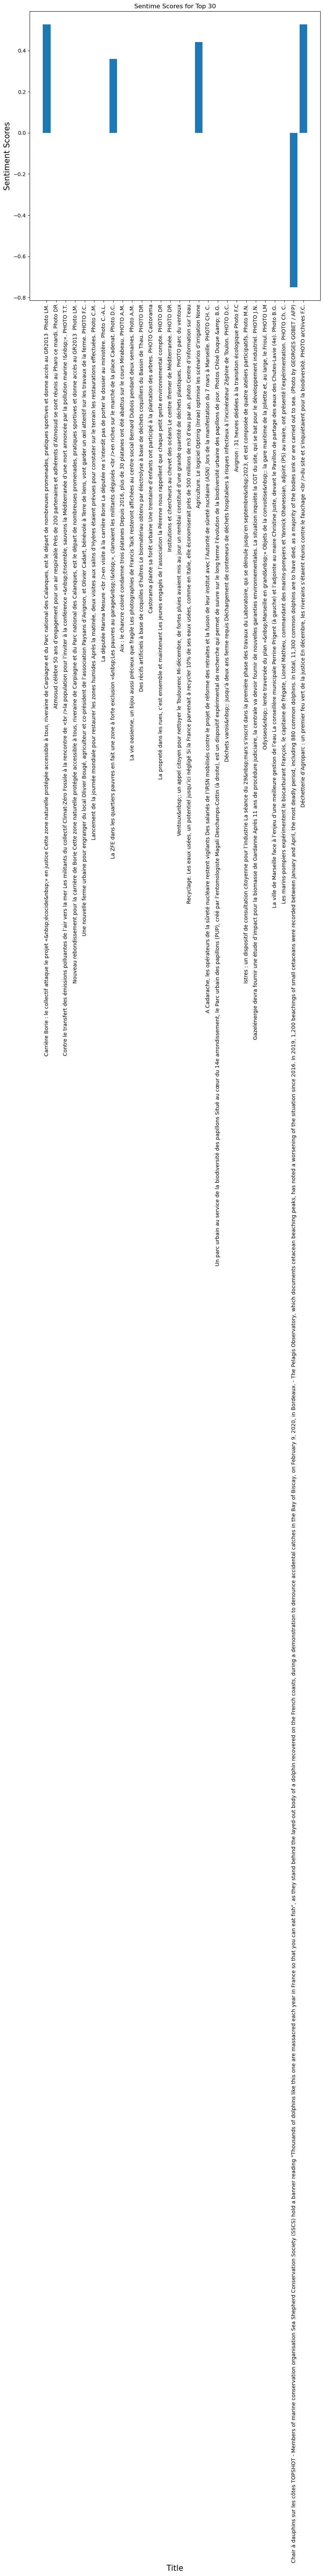

In [40]:
#viz of the polarity scores for top 30 talks
fig = plt.figure(figsize=(10,10))
plt.bar(df_climat.text.head(30),df_climat.sentiment.head(30))
plt.xticks(rotation=90)
plt.title('Sentime Scores for Top 30')
plt.xlabel('Title', fontsize=15)
plt.ylabel('Sentiment Scores', fontsize=15)
plt.show()

- Traitement de texte : 

In [114]:
# Stop words
stop_w = list(set(stopwords.words("french"))) + [
    "[",
    "]",
    ",",
    ".",
    ":",
    "?",
    "(",
    ")",
]

In [115]:
# Tokenizer
def tokenizer_fct(sentence):
    # print(sentence)
    sentence_clean = (
        sentence.replace("-", " ").replace("+", " ").replace("/", " ").replace("#", " ")
    )
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens



def stop_word_filter_fct(list_words):
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    #filtered_w3 = [w for w in filtered_w2 if not w in list_unique_words]
    return filtered_w2


# lower case et alpha
def lower_start_fct(list_words):
    lw = [
        w.lower().strip()
        for w in list_words
        if (not w.startswith("@"))
        and (not w.startswith("#"))
        and (not w.startswith("http"))
    ]
    return lw


# Lemmatizer (base d'un mot)


def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

In [116]:
# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = " ".join(lem_w)
    return transf_desc_text

In [117]:
df_climat["sentence_bow_lem"] = df_climat["text"].apply(lambda x: transform_bow_lem_fct(x))

In [118]:
df_climat.head()

,text,media,sentence_bow_lem
0,"Carrière Borie : le collectif attaque le projet «&nbsp;écocide&nbsp;» en justice Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",lamarseillaise,carrière borie collectif attaque projet nbsp écocide nbsp justice cette zone naturelle protégée accessible tous riveraine carpiagne parc national calanques départ nombreuses promenade pratiques sportives donne accès gr2013 photo
1,Atmosud célèbre 50 ans d’engagement pour un air respirable Près de 200 partenaires et adhérents d’Atmosud se sont réunis au Pharo ce mardi. Photo DR,lamarseillaise,atmosud célèbre an engagement air respirable près 200 partenaires adhérents atmosud réunis pharo mardi photo
2,"Contre le transfert des émissions polluantes de l’air vers la mer Les militants du collectif Climat-Zéro Fossile à la rencontre de <br />la population pour l’inviter à la conférence «&nbsp;Ensemble, sauvons la Méditerranée d’une mort annoncée par la pollution marine !&nbsp;». PHOTO T.T.",lamarseillaise,contre transfert émissions polluantes air vers mer le militant collectif climat zéro fossile rencontre population inviter conférence nbsp ensemble sauvons méditerranée mort annoncée pollution marine nbsp photo t.t
3,"Nouveau rebondissement pour la carrière de Borie Cette zone naturelle protégée accessible à tous, riveraine de Carpiagne et du Parc national des Calanques, est le départ de nombreuses promenades, pratiques sportives et donne accès au GR2013 Photo LM.",lamarseillaise,nouveau rebondissement carrière borie cette zone naturelle protégée accessible tous riveraine carpiagne parc national calanques départ nombreuses promenade pratiques sportives donne accès gr2013 photo
4,"Une nouvelle ferme urbaine pour engranger du local Olivier Bougé, agriculteur et co-président de l’association Paysans d’Avignon, et Olivier Cadart, bénévole à Terre de liens, vont garder un œil attentif sur les travaux de la ferme. PHOTO F.C.",lamarseillaise,une nouvelle ferme urbaine engranger local olivier bougé agriculteur président association paysans avignon olivier cadart bénévole terre lien vont garder œil attentif travaux ferme photo f.c
